# Database creation
This file is used to play with the data and once the objective is reached, functions will be written in .py files in order to be used by the model part of the project.

In [3]:
from astropy.io import fits
from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dataset_creation_utils import *
# Retrieve the contrast curves from the database
path_db = 'C:/Users/ludin/Documents/Master Thesis/Dataset_creation/SPHERE_DC_DATA/'
foldername = '2MASS J01543773+0043005_DB_H23_2014-10-07_ird_specal_dc_cADI_softsorting_200967/'
filename = 'ird_specal_dc-IRD_SPECAL_CONTRAST_CURVE_TABLE-contrast_curve_tab.fits'

if not os.path.exists(path_db):
    print('ERROR! Folder {} does not exist.'.format(path_db)) # exit doesn't print anything in jupyter notebook

if not os.path.exists(os.path.join(path_db, foldername)):
    print('ERROR! Folder {} does not exist.'.format(foldername))

if not os.path.exists(os.path.join(path_db, foldername, filename)):
    print('ERROR! File {} does not exist.'.format(filename))

# Example of how to read a fits file
with fits.open(os.path.join(path_db, foldername, filename)) as hdul:
    data = hdul[1].data #numpy record
    headers = hdul[1].header #dictionary
    print(data.dtype)
    # print(hdul[1].header['DATE-OBS'])
    # print(hdul[1].data['TARGET_NAME'])

(numpy.record, [('TARGET_NAME', 'S3'), ('LAM', 'S10'), ('PIXSCALE', 'S10'), ('NSIGMA', 'S3'), ('REPERTORY', 'S55'), ('SEPARATION', '>f4', (1148,)), ('NSIGMA_CONTRAST', '>f4', (1148,))])


Get a dataframe with the specified headers. Plots, summary statistics, ... can be computed if desired (not to be re-done each time).

In [4]:
df = get_df_with_headers(path_db, ['ESO OBS ID', 'DATE-OBS', 'OBJECT', 'ESO TEL PARANG START', 'ESO TEL PARANG END'],\
     interpolate=True, compute_summary=False, write_headers=False, compute_plots=False, max_sep=3)
df

,folder,ESO OBS ID,DATE-OBS,OBJECT,SEPARATION,NSIGMA_CONTRAST,SIMBAD_FLUX_G,SIMBAD_FLUX_H,DELTA_PARANG
0,++ CVN 3B_DB_H23_2018-09-14_ird_specal_dc_cADI...,2177825,2018-09-15T07:33:22.60,CD-52 381,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.0764733002369364, 0.007057913887455397, 0.0...",10.614176,8.530,50.025
1,++ KOH 78_DB_H23_2016-04-03_ird_specal_dc_cADI...,1182440,2016-04-04T07:59:57.8491,ScoPMS_048,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.013610598683677744, 0.005102142635421004, 0...",14.683154,8.473,2.614
2,++ SKF 1501_DB_H23_2015-04-11_ird_specal_dc_cA...,1182371,2015-04-12T07:15:49.8435,HIP_76629,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.00835001855564525, 0.0022740225957848703, 0...",7.677120,5.994,0.498
3,1RXS J184646.0-363621_DB_H23_2018-07-04_ird_sp...,1962017,2018-07-05T01:24:56.95,RXJ1846,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.12483872406837707, 0.07288618737488416, 0.0...",10.789814,8.469,0.164
4,1RXS J184646.0-363621_DB_H23_2018-07-04_ird_sp...,1962017,2018-07-05T01:24:56.95,RXJ1846,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.12483872406837707, 0.07288618737488416, 0.0...",10.789814,8.469,0.164
...,...,...,...,...,...,...,...,...,...
509,TYC 7692-2943-2_DB_H23_2019-03-19_ird_specal_d...,2296758,2019-03-20T02:23:21.23,TYC 7692-2943-2,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.010639848856919395, 0.002414968575376793, 0...",9.348000,NaN,8.674
510,TYC 7692-2943-2_DB_H23_2019-03-24_ird_specal_d...,2296758,2019-03-25T02:18:36.93,TYC 7692-2943-2,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.007000685686163963, 0.002920603859616869, 0...",9.348000,NaN,35.167
511,TYC 8092-1574-2_DB_H23_2016-10-01_ird_specal_d...,1424674,2016-10-02T08:50:23.1564,HIP 28153,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.007665507957330054, 0.000964130643938169, 0...",12.476170,NaN,1.592
512,TYC 8097-337-1_DB_H23_2018-10-31_ird_specal_dc...,2028801,2018-11-01T07:33:29.10,TYC 8097-337-1,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.006814450366733455, 0.0032717083575035423, ...",11.274122,9.907,34.250


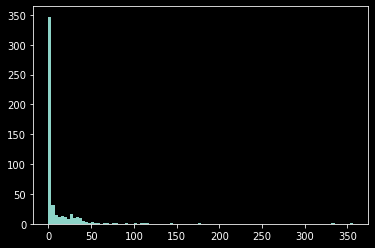

In [5]:
# Plot histogram of the parallactic angles
_ = plt.hist(df['DELTA_PARANG'], bins=100)

We need to determine a minimal value of separation, in order not to extrapolate we look at the max(min(lenghts)) and if it is not to big (otherwise we would loose some important informations)we take it.

In [6]:
separation = df['SEPARATION']
lengths = df.apply(lambda x: len(x['SEPARATION']), axis=1)
mins = df.apply(lambda x: np.min(x['SEPARATION']), axis=1)
print("The min-min of the separation values is: {}".format(np.min(mins)))
print("The max-min of the separation values is {}.".format(np.max(mins)))

The min-min of the separation values is: 0.0306249987334013
The max-min of the separation values is 0.0306249987334013.


In [7]:
# Print the types of the columns
print(df.dtypes)

folder              object
ESO OBS ID           int64
DATE-OBS            object
OBJECT              object
SEPARATION          object
NSIGMA_CONTRAST     object
SIMBAD_FLUX_G      float64
SIMBAD_FLUX_H      float64
DELTA_PARANG       float64
dtype: object


This plot is a summary plot of all the contrast curves, no anomaly detection has been performed.

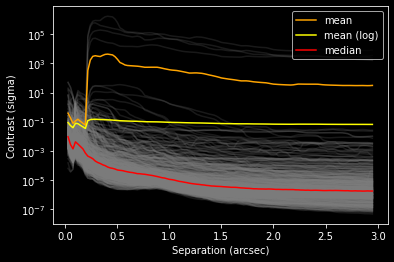

In [8]:
plot_contrast_curves_summary(path_db, df, filename='contrast_curves_summary_raw.png')

Now the sum of the absolute differences between the contrast curves and the median contrast curve (using log values) is used as deviation measure.

In [9]:
df['ABS DEV'] = get_abs_deviations_from_median(df)
# df

The distribution of these deviations is showed and some outliers can be observed.

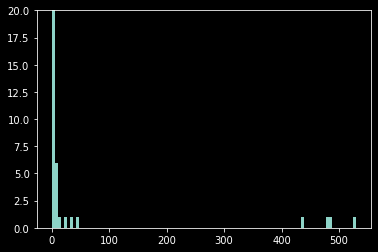

In [10]:
# Plot the distribution of the absolute deviations from the median
plt.hist(df['ABS DEV'], bins=100)	
# plt.xlim(0, 100)
plt.ylim(0, 20)
plt.show()

The cut-off criterion has been chosen (arbitrarly) and a new summary plot has been computed in order to be compared to the previous one.

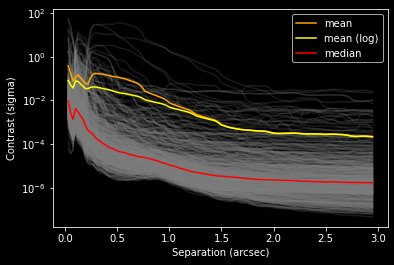

In [11]:
df_AD = remove_contrast_anomalies(path_db, df, threshold=100)

# Plot the new summary of the contrast curves
plot_contrast_curves_summary(path_db, df_AD, filename='contrast_curves_summary_anomaly_detection.png')

In [12]:
df_AD

,folder,ESO OBS ID,DATE-OBS,OBJECT,SEPARATION,NSIGMA_CONTRAST,SIMBAD_FLUX_G,SIMBAD_FLUX_H,DELTA_PARANG,ABS DEV
0,++ CVN 3B_DB_H23_2018-09-14_ird_specal_dc_cADI...,2177825,2018-09-15T07:33:22.60,CD-52 381,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.0764733002369364, 0.007057913887455397, 0.0...",10.614176,8.530,50.025,0.034402
1,++ KOH 78_DB_H23_2016-04-03_ird_specal_dc_cADI...,1182440,2016-04-04T07:59:57.8491,ScoPMS_048,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.013610598683677744, 0.005102142635421004, 0...",14.683154,8.473,2.614,0.004896
2,++ SKF 1501_DB_H23_2015-04-11_ird_specal_dc_cA...,1182371,2015-04-12T07:15:49.8435,HIP_76629,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.00835001855564525, 0.0022740225957848703, 0...",7.677120,5.994,0.498,0.005167
3,1RXS J184646.0-363621_DB_H23_2018-07-04_ird_sp...,1962017,2018-07-05T01:24:56.95,RXJ1846,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.12483872406837707, 0.07288618737488416, 0.0...",10.789814,8.469,0.164,4.846991
4,1RXS J184646.0-363621_DB_H23_2018-07-04_ird_sp...,1962017,2018-07-05T01:24:56.95,RXJ1846,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.12483872406837707, 0.07288618737488416, 0.0...",10.789814,8.469,0.164,4.846991
...,...,...,...,...,...,...,...,...,...,...
509,TYC 7692-2943-2_DB_H23_2019-03-19_ird_specal_d...,2296758,2019-03-20T02:23:21.23,TYC 7692-2943-2,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.010639848856919395, 0.002414968575376793, 0...",9.348000,NaN,8.674,0.003894
510,TYC 7692-2943-2_DB_H23_2019-03-24_ird_specal_d...,2296758,2019-03-25T02:18:36.93,TYC 7692-2943-2,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.007000685686163963, 0.002920603859616869, 0...",9.348000,NaN,35.167,0.005883
511,TYC 8092-1574-2_DB_H23_2016-10-01_ird_specal_d...,1424674,2016-10-02T08:50:23.1564,HIP 28153,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.007665507957330054, 0.000964130643938169, 0...",12.476170,NaN,1.592,0.019931
512,TYC 8097-337-1_DB_H23_2018-10-31_ird_specal_dc...,2028801,2018-11-01T07:33:29.10,TYC 8097-337-1,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.006814450366733455, 0.0032717083575035423, ...",11.274122,9.907,34.250,0.004753


Magnitude import test

In [13]:
import sparta.query_eso_archive as qea
import astropy.coordinates as coord
import astropy.units as u
from astropy.time import Time

In [14]:
# print(headers)
date = Time(headers['DATE-OBS'])
name = headers['OBJECT']
coords = coord.SkyCoord(headers['RA']*u.degree,headers['DEC']*u.degree)
# print(coords)
simbad_dico = qea.query_simbad(date, coords, name)
print(simbad_dico)

One star found: TYC   30-78-1 with G=11.4
Distance between the current star position and pointing position: 3.8arcsec
{'simbad_MAIN_ID': 'TYC   30-78-1', 'simbad_RA_ICRS': '01 54 37.7260', 'simbad_DEC_ICRS': '+00 43 00.563', 'simbad_FLUX_V': 11.545999526977539, 'simbad_FLUX_R': 11.253000259399414, 'simbad_FLUX_G': 11.424246788024902, 'simbad_FLUX_I': 10.954000473022461, 'simbad_FLUX_J': 10.560999870300293, 'simbad_FLUX_H': 10.319999694824219, 'simbad_FLUX_K': 10.26099967956543, 'simbad_ID_HD': '', 'simbad_SP_TYPE': 'F5', 'simbad_OTYPE': 'Star', 'simbad_OTYPE_V': 'Star', 'simbad_OTYPE_3': '*', 'simbad_PMRA': -10.387, 'simbad_PMDEC': -18.452, 'simbad_RA_current': '01 54 37.7173', 'simbad_DEC_current': '+00 43 00.289', 'DEC': '0 42 57.744', 'RA': '1 54 37.90152', 'simbad_separation_RADEC_ICRSJ2000': 3.857112018032784, 'simbad_separation_RADEC_current': 3.756548708640729}
